In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import yfinance as yf

In [ ]:
ticker = yf.Ticker("TSLA")

start_date = "2018-01-01"
end_date = "2023-12-31"

df = ticker.history(start=start_date, end=end_date)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-01-02 00:00:00-05:00,20.799999,21.474001,20.733334,21.368668,65283000,0.0,0.0
2018-01-03 00:00:00-05:00,21.400000,21.683332,21.036667,21.150000,67822500,0.0,0.0
2018-01-04 00:00:00-05:00,20.858000,21.236668,20.378668,20.974667,149194500,0.0,0.0
2018-01-05 00:00:00-05:00,21.108000,21.149332,20.799999,21.105333,68868000,0.0,0.0
2018-01-08 00:00:00-05:00,21.066668,22.468000,21.033333,22.427334,147891000,0.0,0.0


In [ ]:
df2 = df.copy(deep=True)
scaler = MinMaxScaler()

print(df2)
print(df2.shape)

                                 Open        High         Low       Close  \
Date                                                                        
2018-01-02 00:00:00-05:00   20.799999   21.474001   20.733334   21.368668   
2018-01-03 00:00:00-05:00   21.400000   21.683332   21.036667   21.150000   
2018-01-04 00:00:00-05:00   20.858000   21.236668   20.378668   20.974667   
2018-01-05 00:00:00-05:00   21.108000   21.149332   20.799999   21.105333   
2018-01-08 00:00:00-05:00   21.066668   22.468000   21.033333   22.427334   
...                               ...         ...         ...         ...   
2023-12-22 00:00:00-05:00  256.760010  258.220001  251.369995  252.539993   
2023-12-26 00:00:00-05:00  254.490005  257.970001  252.910004  256.609985   
2023-12-27 00:00:00-05:00  258.350006  263.339996  257.519989  261.440002   
2023-12-28 00:00:00-05:00  263.660004  265.130005  252.710007  253.179993   
2023-12-29 00:00:00-05:00  255.100006  255.190002  247.429993  248.479996   

In [ ]:
df2['Close'] = scaler.fit_transform(df2['Close'].values.reshape(-1,1))
data = df2[['Close']].values.reshape(-1,1)

print(data)
print(data.shape)

[[0.02370959]
 [0.02316023]
 [0.02271974]
 ...
 [0.6268453 ]
 [0.60609353]
 [0.59428564]]
(1509, 1)


In [ ]:
seq_len = 11 # 시퀀스 길이 11로 설정, 10개의 이전 데이터를 이용해서 다음 값을 예측
sequences = []

for index in range(len(data) - seq_len + 1):
    sequences.append(data[index : index+seq_len])
sequences = np.array(sequences)

x = sequences[:, :-1]
y = sequences[:, -1]

print(x)
print(x.shape)
print(y)
print(y.shape)

[[[0.02370959]
  [0.02316023]
  [0.02271974]
  ...
  [0.02662723]
  [0.02633748]
  [0.02698063]]

 [[0.02316023]
  [0.02271974]
  [0.02304801]
  ...
  [0.02633748]
  [0.02698063]
  [0.02816979]]

 [[0.02271974]
  [0.02304801]
  [0.0263693 ]
  ...
  [0.02698063]
  [0.02816979]
  [0.027736  ]]

 ...

 [[0.56546934]
  [0.57119742]
  [0.60074231]
  ...
  [0.6094098 ]
  [0.60448564]
  [0.61471076]]

 [[0.57119742]
  [0.60074231]
  [0.60689749]
  ...
  [0.60448564]
  [0.61471076]
  [0.6268453 ]]

 [[0.60074231]
  [0.60689749]
  [0.60333   ]
  ...
  [0.61471076]
  [0.6268453 ]
  [0.60609353]]]
(1499, 10, 1)
[[0.02816979]
 [0.027736  ]
 [0.02864881]
 ...
 [0.6268453 ]
 [0.60609353]
 [0.59428564]]
(1499, 1)


In [ ]:
test = int(len(x) * 0.2)
print(test)

299


In [ ]:
x_train = x[:len(x)-test]
y_train = y[:len(x)-test]

x_test = x[len(x)-test: ]
y_test = y[len(x)-test: ]

print(x_train.shape)
print(x_test.shape)

print(y_train.shape)
print(y_test.shape)

(1200, 10, 1)
(299, 10, 1)
(1200, 1)
(299, 1)


In [ ]:
x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()

x_test = torch.tensor(x_test).float()
y_test = torch.tensor(y_test).float()

print('Training Shape', x_train.shape, y_train.shape) # x(데이터개수(배치크기), 시퀀스길이, 입력하는 값의 차원)
print('Testing Shape', x_test.shape, y_test.shape) # y(데이터개수(배치크기), 출력하는 값의 차원)

Training Shape torch.Size([1200, 10, 1]) torch.Size([1200, 1])
Testing Shape torch.Size([299, 10, 1]) torch.Size([299, 1])


In [ ]:
class LSTM(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTM, self).__init__()
    self.num_classes = num_classes # 클래스의 개수
    self.num_layers = num_layers # LSTM 계층의 개수
    self.input_size = input_size # 입력 크기 / 훈련 데이터셋의 칼럼 개수를 의미
    self.hidden_size = hidden_size # 은닉층의 뉴런 개수
    self.seq_length = seq_length # 시퀀스 길이

    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    self.fc1 = nn.Linear(hidden_size, 128) # 완전연결층
    self.fc = nn.Linear(128, num_classes)
    self.relu = nn.ReLU()

  def forward(self, x):
    h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) # 은닉상태 0으로 초기화
    c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) # 셀상태 0으로 초기화
    output, (hn, cn) = self.lstm(x, (h_0, c_0))
    hn = hn.view(-1, self.hidden_size) # 완전연결층 적용을 위해 데이터의 형태 조정(1차원으로)
    out = self.relu(hn)
    out = self.fc1(out)
    out = self.relu(out)
    out = self.fc(out)
    return out

In [ ]:
num_epochs = 1000
learning_rate = 0.001

input_size = 1 # 각 시간 단계에서 입력되는 특성의 개수
hidden_size = 2 # 은닉층의 뉴런/유닛 개수
num_layers = 1 # LSTM 계층의 개수
seq_length = 10 # 시퀀스의 길이 / 각 입력 샘플이 10개의 시간 단계를 가지고 있음

num_classes = 1 #모델이 예측해야하는 클래스의 개수 / 주가(종가) 데이터의 클래스의 개수는 1
model = LSTM(num_classes, input_size, hidden_size, num_layers, seq_length)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(1, num_epochs+1):
  outputs = model.forward(x_train)
  optimizer.zero_grad()
  loss = criterion(outputs, y_train)
  loss.backward()
  optimizer.step()

  if epoch % 100 == 0:
    print('Epoch : {} Loss : {}'.format(epoch, loss.item()))

Epoch : 100 Loss : 0.08489584177732468
Epoch : 200 Loss : 0.004051173571497202
Epoch : 300 Loss : 0.0006538008456118405
Epoch : 400 Loss : 0.0005249195382930338
Epoch : 500 Loss : 0.0004980726516805589
Epoch : 600 Loss : 0.0004837220476474613
Epoch : 700 Loss : 0.0004728602943941951
Epoch : 800 Loss : 0.00046481972094625235
Epoch : 900 Loss : 0.0004575280472636223
Epoch : 1000 Loss : 0.0004496480105444789


In [ ]:
predict = model(x_test)

In [ ]:
predict_inverse = scaler.inverse_transform(predict.detach().numpy())
actual_inverse = scaler.inverse_transform(y_test)

print('MSE : ', mean_squared_error(actual_inverse, predict_inverse))
print('RMSE : ', np.sqrt(mean_squared_error(actual_inverse, predict_inverse)))

MSE :  88.04839118852453
RMSE :  9.383410424175452


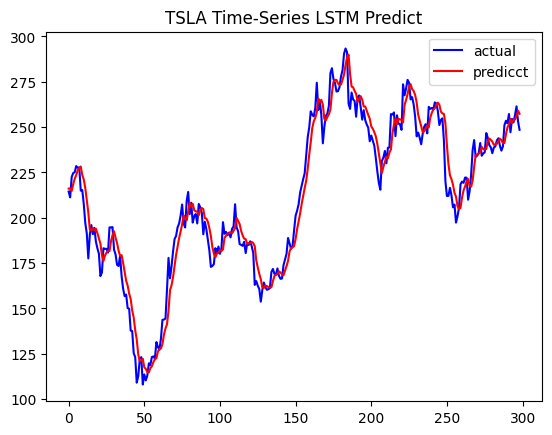

In [ ]:
plt.plot(actual_inverse, color='blue', label='actual')
plt.plot(predict_inverse, color='red', label='predicct')
plt.title("TSLA Time-Series LSTM Predict")
plt.legend()
plt.show()